# Risk Assesment and Management
- **Erdem Sirel**
- **Gizem Yıldırım**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import scipy.stats as stats
import os

In [2]:
print("Current version:", pd.__version__, "our_version:", "1.0.5")

Current version: 1.0.5 our_version: 1.0.5


# Phase I

### Import and process data
15 stocks have been chosen randomly from BIST100 index. Weekly price data is imported from investing.com for each stock.

In [3]:
def import_and_prepare_data():
    path = os.path.join(os.getcwd(), "data")
    files = [file for file in os.listdir(path) if file.endswith("csv")]

    data = pd.DataFrame()
    for file in files:
        file_data = pd.read_csv(os.path.join(path,file))
        file_data["Şirket"] = file[: file.find(" ")]
        data = data.append(file_data)
    return data

try:
    data = pd.read_csv("https://raw.githubusercontent.com/ahmetsirel/ETM959_Risk_Project/master/data.csv", sep=';')
except:
    data = import_and_prepare_data()
    data.to_csv("data.csv", sep=';', index=False)
    print("data prepared from raw files")
    
data.head(5)

,Tarih,Şimdi,Açılış,Yüksek,Düşük,Hac.,Fark %,Şirket
0,06.12.2020,"21,72","22,14","22,68","21,62","3,54M","-1,90%",AEFES
1,29.11.2020,"22,14","22,46","22,82","20,94","44,57M","-1,51%",AEFES
2,22.11.2020,"22,48","22,24","23,98","21,98","12,85M","1,35%",AEFES
3,15.11.2020,"22,18","22,64","22,82","21,38","10,99M","-1,86%",AEFES
4,08.11.2020,"22,60","21,64","22,90","21,20","13,11M","5,81%",AEFES


In [4]:
# Selected assests
data['Şirket'].unique()

array(['AEFES', 'AKBNK', 'DEVA', 'DGKLB', 'ECILC', 'ENJSA', 'ENKAI',
       'GOLTS', 'IHLGM', 'SISE', 'THYAO', 'TTKOM', 'TTRAK', 'ULKER',
       'VESTL'], dtype=object)

In [5]:
# Process Columns
data.rename({"Fark %": "return"}, axis=1, inplace=True)
data["Tarih"] = pd.to_datetime(data["Tarih"], dayfirst=True)
data[["Şimdi", "Açılış", "Yüksek", "Düşük"]] = data[
    ["Şimdi", "Açılış", "Yüksek", "Düşük"]
].applymap(lambda x: round(float(str(x).replace(",", ".")), 3))
data["return"] = data["return"].apply(
    lambda x: round(float(str(x).replace(",", ".").replace("%", "")) / 100, 3)
)
data = data[["Şirket", "Tarih", "Şimdi", "return"]]

data.head()

,Şirket,Tarih,Şimdi,return
0,AEFES,2020-12-06,21.72,-0.019
1,AEFES,2020-11-29,22.14,-0.015
2,AEFES,2020-11-22,22.48,0.014
3,AEFES,2020-11-15,22.18,-0.019
4,AEFES,2020-11-08,22.60,0.058


### Interest Rates

Weekly interest rate is calculated as follows, \begin{equation*} weekly\ interest = (annual\ interest / 365) * 7 \end{equation*}

Source:  
https://www.tcmb.gov.tr/wps/wcm/connect/TR/TCMB+TR/Main+Menu/Temel+Faaliyetler/Para+Politikasi/Merkez+Bankasi+Faiz+Oranlari/1+Hafta+Repo

In [6]:
#Interst Rates
interest_rates = pd.DataFrame([["13 09 2019",	16.50],
                                ["25 10 2019",	14.00],
                                ["13 12 2019",	12.00],
                                ["17 01 2020",	11.25],
                                ["20 02 2020",	10.75],
                                ["18 03 2020",	9.75],
                                ["23 04 2020",	8.75],
                                ["22 05 2020",	8.25],
                                ["25 09 2020",	10.25],
                                ["20 11 2020",	15.00]],
                            columns=["date", "rate"])
interest_rates["date"] = pd.to_datetime(interest_rates["date"], dayfirst=True) 
interest_rates["rate"] = interest_rates["rate"] / 100
interest_rates = interest_rates.set_index("date")
interest_rates = (interest_rates / 365) * 7 #convert to weekly interest
interest_rates = interest_rates.sort_index(ascending=False)
interest_rates.head()

,rate
date,
2020-11-20,0.002877
2020-09-25,0.001966
2020-05-22,0.001582
2020-04-23,0.001678
2020-03-18,0.001870


####  Calculate net return by substracting the weekly inflation rate from weekly return

In [7]:
def get_interst(date_):
    return interest_rates[interest_rates.index <=date_].head(1)["rate"].values[0]
data["inflation"] = data.apply(lambda row: get_interst(row["Tarih"]) ,axis=1)
data["net_return"] = data["return"] - data["inflation"]

data = data.sort_values(["Şirket", "Tarih"])
data.head()

,Şirket,Tarih,Şimdi,return,inflation,net_return
51,AEFES,2019-12-15,22.32,0.013,0.002301,0.010699
50,AEFES,2019-12-22,23.34,0.046,0.002301,0.043699
49,AEFES,2019-12-29,23.08,-0.011,0.002301,-0.013301
48,AEFES,2020-01-05,23.62,0.023,0.002301,0.020699
47,AEFES,2020-01-12,25.58,0.083,0.002301,0.080699


### Aggregate data
**Calculate mean & standard deviation for each stock**

In [8]:
#Mean & Standard Deviations for weekly return
data_agg = data.groupby("Şirket").agg({"return": ["mean","std"]})
data_agg.columns = data_agg.columns.get_level_values(1)
mean_returns = data_agg["mean"]

#Mean & Standard Deviations for weekly net return
data_agg_net = data.groupby("Şirket").agg({"net_return": ["mean", "std"]})
data_agg_net.columns = data_agg_net.columns.get_level_values(1)
mean_net_returns = data_agg_net["mean"]

### Covariance Calculation

In [9]:
# Cov for weekly return
cov_data = pd.DataFrame()
for company in data["Şirket"].unique():
    current = data[data["Şirket"] == company]["return"].rename(company).reset_index(drop=True)
    cov_data = pd.concat([cov_data, current], axis=1)
cov = cov_data.cov()

# Cov for weekly net return
cov_data_net = pd.DataFrame()
for company in data["Şirket"].unique():
    current_ = data[data["Şirket"] == company]["net_return"].rename(company).reset_index(drop=True)
    cov_data_net = pd.concat([cov_data_net, current_], axis=1)
cov_net = cov_data_net.cov()

In [10]:
cov # Cov for weekly return

,AEFES,AKBNK,DEVA,DGKLB,ECILC,ENJSA,ENKAI,GOLTS,IHLGM,SISE,THYAO,TTKOM,TTRAK,ULKER,VESTL
AEFES,0.002998,0.002193,0.000948,0.002333,0.000426,0.001271,0.000660,0.002302,0.002244,0.001525,0.002317,0.002115,0.001739,0.001849,0.002098
AKBNK,0.002193,0.003918,0.000899,0.001814,0.000825,0.001032,0.000482,0.002027,0.002299,0.001421,0.002904,0.002853,0.001702,0.001897,0.002190
DEVA,0.000948,0.000899,0.009104,0.002961,0.006473,0.001256,-0.000021,0.002131,0.001536,0.000334,0.001769,0.002081,0.001887,0.001552,0.001704
DGKLB,0.002333,0.001814,0.002961,0.008816,0.001931,0.001911,0.002231,0.003657,0.004289,0.001806,0.002962,0.002771,0.003574,0.002002,0.003496
ECILC,0.000426,0.000825,0.006473,0.001931,0.009053,-0.000039,0.000131,0.001606,0.003260,0.000316,0.001753,0.001951,0.001333,0.001196,0.001402
ENJSA,0.001271,0.001032,0.001256,0.001911,-0.000039,0.001804,0.000408,0.001776,0.001162,0.000730,0.001078,0.001211,0.001354,0.001019,0.001470
ENKAI,0.000660,0.000482,-0.000021,0.002231,0.000131,0.000408,0.001673,0.000836,0.001005,0.000823,0.000537,0.000548,0.001022,0.000640,0.001022
GOLTS,0.002302,0.002027,0.002131,0.003657,0.001606,0.001776,0.000836,0.006353,0.003488,0.001553,0.002502,0.002107,0.002989,0.002200,0.002901
IHLGM,0.002244,0.002299,0.001536,0.004289,0.003260,0.001162,0.001005,0.003488,0.008453,0.001548,0.003038,0.002635,0.003327,0.002759,0.003343
SISE,0.001525,0.001421,0.000334,0.001806,0.000316,0.000730,0.000823,0.001553,0.001548,0.002660,0.001674,0.001664,0.001386,0.001249,0.001445


In [11]:
cov_net # Cov for weekly net return

,AEFES,AKBNK,DEVA,DGKLB,ECILC,ENJSA,ENKAI,GOLTS,IHLGM,SISE,THYAO,TTKOM,TTRAK,ULKER,VESTL
AEFES,0.003001,0.002195,0.000951,0.002339,0.000429,0.001272,0.000663,0.002303,0.002246,0.001529,0.002319,0.002116,0.001743,0.001851,0.002099
AKBNK,0.002195,0.003919,0.000901,0.001818,0.000828,0.001032,0.000484,0.002028,0.002300,0.001424,0.002905,0.002853,0.001705,0.001898,0.002191
DEVA,0.000951,0.000901,0.009107,0.002967,0.006476,0.001256,-0.000018,0.002132,0.001538,0.000337,0.001771,0.002082,0.001891,0.001554,0.001705
DGKLB,0.002339,0.001818,0.002967,0.008825,0.001937,0.001914,0.002238,0.003661,0.004295,0.001813,0.002967,0.002775,0.003581,0.002007,0.003501
ECILC,0.000429,0.000828,0.006476,0.001937,0.009057,-0.000038,0.000135,0.001608,0.003262,0.000321,0.001755,0.001953,0.001338,0.001198,0.001404
ENJSA,0.001272,0.001032,0.001256,0.001914,-0.000038,0.001803,0.000409,0.001776,0.001162,0.000731,0.001078,0.001210,0.001356,0.001018,0.001469
ENKAI,0.000663,0.000484,-0.000018,0.002238,0.000135,0.000409,0.001678,0.000839,0.001008,0.000827,0.000540,0.000550,0.001027,0.000643,0.001024
GOLTS,0.002303,0.002028,0.002132,0.003661,0.001608,0.001776,0.000839,0.006354,0.003489,0.001556,0.002503,0.002108,0.002992,0.002201,0.002902
IHLGM,0.002246,0.002300,0.001538,0.004295,0.003262,0.001162,0.001008,0.003489,0.008455,0.001551,0.003039,0.002636,0.003330,0.002761,0.003344
SISE,0.001529,0.001424,0.000337,0.001813,0.000321,0.000731,0.000827,0.001556,0.001551,0.002665,0.001677,0.001666,0.001391,0.001251,0.001448


### Calculating the portfolio weights
5.Form two portfolios using different weights,   
* one where weights increase proportional to decreasing standard deviations of individual assets and 


* one where weights decrease as average returns decrease.  Calculate the means and variancesof both portfolios.
<blockquote>For this one we had a negative mean return for AKBNK. We took its mean as zero in order to calculate proper weight for portfolio. ("mean_for_p1") </blockquote>


**Calculate the weights of Portfolio 1**

In [12]:
data_agg["mean_for_p1"] = data_agg["mean"].apply(lambda x: max([x, 0]))
data_agg['Portfolio1'] = data_agg["mean_for_p1"] / data_agg["mean_for_p1"].sum()
p1_weights = data_agg['Portfolio1']

**Calculate the weights of Portfolio 2**
$$step1_i= \frac{\sum_{j=1}^n std_j}{var_i}$$

$$weight_i= \frac{step1_i}{\sum_{k=1}^n step1_k}$$

In [13]:
data_agg["std_for_p2"] =  data_agg["std"].sum() / data_agg["std"]
data_agg['Portfolio2'] =  data_agg["std_for_p2"] / data_agg["std_for_p2"].sum()
p2_weights = data_agg['Portfolio2']

print("Check weights for portfolio 1:", round(p1_weights.sum(),3))
print("Check weights for portfolio 2:",round(p2_weights.sum(),3))

Check weights for portfolio 1: 1.0
Check weights for portfolio 2: 1.0


In [14]:
data_agg.sort_values("std")

,mean,std,mean_for_p1,Portfolio1,std_for_p2,Portfolio2
Şirket,,,,,,
ENKAI,0.004135,0.040907,0.004135,0.028667,25.072040,0.103512
ENJSA,0.008019,0.042478,0.008019,0.055600,24.145054,0.099685
SISE,0.008385,0.051576,0.008385,0.058133,19.885674,0.082099
ULKER,0.001673,0.054159,0.001673,0.011600,18.937260,0.078184
AEFES,0.001135,0.054754,0.001135,0.007867,18.731498,0.077334
TTKOM,0.003731,0.059723,0.003731,0.025867,17.173252,0.070901
AKBNK,-0.002769,0.062592,0.000000,0.000000,16.386080,0.067651
THYAO,0.000115,0.066195,0.000115,0.000800,15.494137,0.063969
VESTL,0.012788,0.068344,0.012788,0.088667,15.006874,0.061957


In [15]:
data_agg.loc["DEVA","std"] / data_agg.loc["ULKER","std"]

1.761780682013892

In [16]:
data_agg.loc["ULKER","Portfolio2"] / data_agg.loc["DEVA","Portfolio2"]

1.7617806820138924

### Calculate Portfolio Parameters
 - Mean return of the portfolio (w)
 - Variance of the portfolio

### Return

**Portfolio 1**

##### Mean & Variance Calculation

In [17]:
# multiply weights
def mul_weight(row_column):
    
    return np.multiply(row_column, p1_weights)
# Multiply relavant stock weights for each covariance to calculated portfolio covariance.
cov_p1 = cov.apply(mul_weight, axis=1).apply(mul_weight, axis=0)

In [18]:
p1_parameters = pd.DataFrame.from_dict({"Mean return of the portfolio (w)": [np.matmul(p1_weights, mean_returns)],
                                        "Variance of the portfolio": [cov_p1.sum().sum()]}).rename({0:"Portfolio 1"})
p1_parameters

,Mean return of the portfolio (w),Variance of the portfolio
Portfolio 1,0.015832,0.002735


**Portfolio 2**

In [19]:
# multiply weights
def mul_weight2(row_column):
    
    return np.multiply(row_column, p2_weights)
# Multiply relavant stock weights for each covariance to calculated portfolio covariance.
cov_p2 = cov.apply(mul_weight2, axis=1).apply(mul_weight2, axis=0)

In [20]:

p2_parameters = pd.DataFrame.from_dict({"Mean return of the portfolio (w)": [np.matmul(p2_weights, mean_returns)],
                                        "Variance of the portfolio": [cov_p2.sum().sum()]}).rename({0:"Portfolio 2"})
p2_parameters

,Mean return of the portfolio (w),Variance of the portfolio
Portfolio 2,0.008211,0.001797


### Portfolio Parameters for return (without inflation)

In [21]:
portfolio_parameters = p1_parameters.append(p2_parameters)
portfolio_parameters

,Mean return of the portfolio (w),Variance of the portfolio
Portfolio 1,0.015832,0.002735
Portfolio 2,0.008211,0.001797


### Net Return

#### Portfolio 1

In [22]:
# multiply weights
def mul_weight(row_column):
    
    return np.multiply(row_column, p1_weights)

cov_p1_net = cov_net.apply(mul_weight, axis=1).apply(mul_weight, axis=0)

In [23]:
p1_parameters_net = pd.DataFrame.from_dict({"Mean net return of the portfolio (w)": [np.matmul(p1_weights, mean_net_returns)],
                                        "Variance of the portfolio": [cov_p1_net.sum().sum()]}).rename({0:"Portfolio 1"})


#### Portfolio 2

In [24]:
# multiply weights
def mul_weight2(row_column):
    
    return np.multiply(row_column, p2_weights)

cov_p2_net = cov.apply(mul_weight2, axis=1).apply(mul_weight2, axis=0)

In [25]:

p2_parameters_net = pd.DataFrame.from_dict({"Mean net return of the portfolio (w)": [np.matmul(p2_weights, mean_net_returns)],
                                        "Variance of the portfolio": [cov_p2_net.sum().sum()]}).rename({0:"Portfolio 2"})


### Portfolio Parameters for return (with inflation)

In [26]:
portfolio_parameters_net = p1_parameters_net.append(p2_parameters_net)
portfolio_parameters_net

,Mean net return of the portfolio (w),Variance of the portfolio
Portfolio 1,0.013920,0.002738
Portfolio 2,0.006299,0.001797


### 6.1 Probability of Gaining Positive Return
Assuming the average weekly return of a portfolio is normally distributed with
the parameter values you have collected   
calculate the **probability of gaining a
positive return**   
and the probability of gaining a return above the inflation rate
(rate banks loan money). You need weekly rates. 

In [27]:
portfolio_parameters

,Mean return of the portfolio (w),Variance of the portfolio
Portfolio 1,0.015832,0.002735
Portfolio 2,0.008211,0.001797


In [28]:
portfolio_parameters["z-value"] = (
    (0 - portfolio_parameters["Mean return of the portfolio (w)"]) / 
        np.sqrt(portfolio_parameters[ "Variance of the portfolio"])
                                    )
portfolio_parameters["p-value"] = portfolio_parameters["z-value"].apply(lambda z: stats.norm.sf(abs(z)))
portfolio_parameters["probability"] = 1- portfolio_parameters["p-value"] 

In [29]:
portfolio_parameters

,Mean return of the portfolio (w),Variance of the portfolio,z-value,p-value,probability
Portfolio 1,0.015832,0.002735,-0.302729,0.381048,0.618952
Portfolio 2,0.008211,0.001797,-0.193712,0.423201,0.576799


#### Result
Probability of gaining a positive return:  
Portfolio1: 61.8%  
Portfolio2: 57.6%

### 6.2 Probability of Gaining Return Above Inflation
Assuming the average weekly return of a portfolio is normally distributed with
the parameter values you have collected   
calculate the probability of gaining a
positive return   
and the **probability of gaining a return above the inflation rate**
(rate banks loan money). You need weekly rates. 

In [30]:
portfolio_parameters_net

,Mean net return of the portfolio (w),Variance of the portfolio
Portfolio 1,0.013920,0.002738
Portfolio 2,0.006299,0.001797


In [31]:
portfolio_parameters_net["z-value"] = (
    (0 - portfolio_parameters_net["Mean net return of the portfolio (w)"]) / 
         np.sqrt(portfolio_parameters_net[ "Variance of the portfolio"])
                                    )
portfolio_parameters_net["p-value"] = portfolio_parameters_net["z-value"].apply(lambda z: stats.norm.sf(abs(z)))
portfolio_parameters_net["probability"] = 1- portfolio_parameters_net["p-value"] 

In [32]:
portfolio_parameters_net

,Mean net return of the portfolio (w),Variance of the portfolio,z-value,p-value,probability
Portfolio 1,0.013920,0.002738,-0.266021,0.395112,0.604888
Portfolio 2,0.006299,0.001797,-0.148597,0.440936,0.559064


#### Result
Probability of gaining a return above the inflation rate:  
Portfolio1: 60.4%  
Portfolio2: 55.9%

# Phase II

**Q1.Find the weights using the Markowitz model for different target return rates. Analyze the
shorting and no shorting cases. (Use Excelsolver or equivalent for quadratic optimization)**

In [33]:
import scipy.optimize as optimize

In [34]:
def portfolio_parameters(weights, returns):
    
    '''
    We can gather the portfolio performance metrics for a specific set of weights.
    This function will be important because we'll want to pass it to an optmization
    function to get the portfolio with the best desired characteristics.
    
    Note: Sharpe ratio here uses a risk-free short rate of 0.
    
    Paramaters: 
    -----------
        weights: array, 
            asset weights in the portfolio.
        returns: dataframe
            a dataframe of returns for each asset in the trial portfolio    
    
    Returns: 
    --------
        dict of portfolio statistics - mean return, volatility, standard dev.
    '''

    # Convert to array in case list was passed instead.
    weights = np.array(weights)
    port_return = np.sum(returns.mean() * weights)
    port_var = np.dot(weights.T, np.dot(returns.cov(), weights))

    return {'return': port_return, 'variance': port_var, 'std': np.sqrt(port_var)}

In [35]:
returns = cov_data

In [36]:
# Objective Function
def minimize_volatility(weights):  
    return portfolio_parameters(weights, returns)['std'] 

##### Shorting Allowed

In [37]:
num_assets = len(returns.columns)
target_returns = [0.01, 0.015, 0.02, 0.025]

portfolio_list_shorting_allowed=pd.DataFrame()
for target_return in target_returns:
    constraints = ({'type':'eq','fun': lambda weights: portfolio_parameters(weights, returns)['return']-target_return},
                   {'type':'eq','fun': lambda weights: np.sum(weights)-1})
    #bounds = tuple((0,1) for x in range(num_assets))
    initializer = num_assets * [1./num_assets,]

    optimal_variance=optimize.minimize(fun=minimize_volatility,
                                     x0=initializer,
                                     method = 'SLSQP',
                                     #bounds = bounds,
                                     constraints = constraints)

    weights_ = optimal_variance['x'].round(4)  
    weights_df = pd.DataFrame(weights_, index=returns.columns).T.rename({0:target_return},axis=0)
    portfolio_parameters_df = pd.DataFrame.from_dict(portfolio_parameters(weights_, returns), orient='index').T.rename({0:target_return},axis=0)
    portfolio_summary = pd.concat([weights_df,portfolio_parameters_df], axis=1)
    portfolio_list_shorting_allowed = portfolio_list_shorting_allowed.append(portfolio_summary)

##### Shorting not Allowed

In [38]:
num_assets = len(returns.columns)
target_returns = [0.01, 0.015, 0.02, 0.025]

portfolio_list_shorting_not_allowed=pd.DataFrame()
for target_return in target_returns:
    constraints = ({'type':'eq','fun': lambda weights: portfolio_parameters(weights, returns)['return']-target_return},
                   {'type':'eq','fun': lambda weights: np.sum(weights)-1})
    bounds = tuple((0,1) for x in range(num_assets))
    initializer = num_assets * [1./num_assets,]

    optimal_variance=optimize.minimize(fun=minimize_volatility,
                                     x0=initializer,
                                     method = 'SLSQP',
                                     bounds = bounds,
                                     constraints = constraints)

    weights_ = optimal_variance['x'].round(4)  
    weights_df = pd.DataFrame(weights_, index=returns.columns).T.rename({0:target_return},axis=0)
    portfolio_parameters_df = pd.DataFrame.from_dict(portfolio_parameters(weights_, returns), orient='index').T.rename({0:target_return},axis=0)
    portfolio_summary = pd.concat([weights_df,portfolio_parameters_df], axis=1)
    portfolio_list_shorting_not_allowed = portfolio_list_shorting_not_allowed.append(portfolio_summary)

In [39]:
portfolio_list_shorting_allowed

,AEFES,AKBNK,DEVA,DGKLB,ECILC,ENJSA,ENKAI,GOLTS,IHLGM,SISE,THYAO,TTKOM,TTRAK,ULKER,VESTL,return,variance,std
0.010,-0.0202,0.0020,0.0518,-0.2012,0.1041,0.4492,0.4608,-0.0241,0.0138,0.1708,0.0019,-0.0567,0.1339,-0.1009,0.0147,0.009998,0.000826,0.028746
0.015,-0.0406,-0.0167,0.1059,-0.2227,0.0917,0.4356,0.4178,-0.0045,0.0346,0.2473,-0.0805,-0.0625,0.2412,-0.2379,0.0912,0.014999,0.001131,0.033624
0.020,-0.0597,-0.0310,0.1610,-0.2436,0.0788,0.4222,0.3751,0.0159,0.0580,0.3205,-0.1652,-0.0689,0.3479,-0.3779,0.1669,0.020000,0.001609,0.040113
0.025,-0.0714,-0.0358,0.2178,-0.2607,0.0666,0.4033,0.3407,0.0301,0.0790,0.3962,-0.2632,-0.0804,0.4550,-0.5238,0.2466,0.025000,0.002261,0.047547


In [40]:
portfolio_list_shorting_not_allowed

,AEFES,AKBNK,DEVA,DGKLB,ECILC,ENJSA,ENKAI,GOLTS,IHLGM,SISE,THYAO,TTKOM,TTRAK,ULKER,VESTL,return,variance,std
0.010,0.0,0.0,0.0399,0.0,0.0966,0.3314,0.2969,0.0,0.0,0.1295,0.0,0.0,0.1056,0.0,0.0,0.009998,0.001087,0.032972
0.015,0.0,0.0,0.1421,0.0,0.0482,0.1887,0.1654,0.0,0.0,0.1411,0.0,0.0,0.3145,0.0,0.0,0.015001,0.001712,0.041376
0.020,0.0,0.0,0.2437,0.0,0.0000,0.0541,0.0369,0.0,0.0,0.1406,0.0,0.0,0.5247,0.0,0.0,0.020000,0.002784,0.052766
0.025,0.0,0.0,1.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.024019,0.009104,0.095417


---

**Q2.Using the results generate the efficient frontier for your portfolio.**

Text(0, 0.5, 'Portfolio Return')

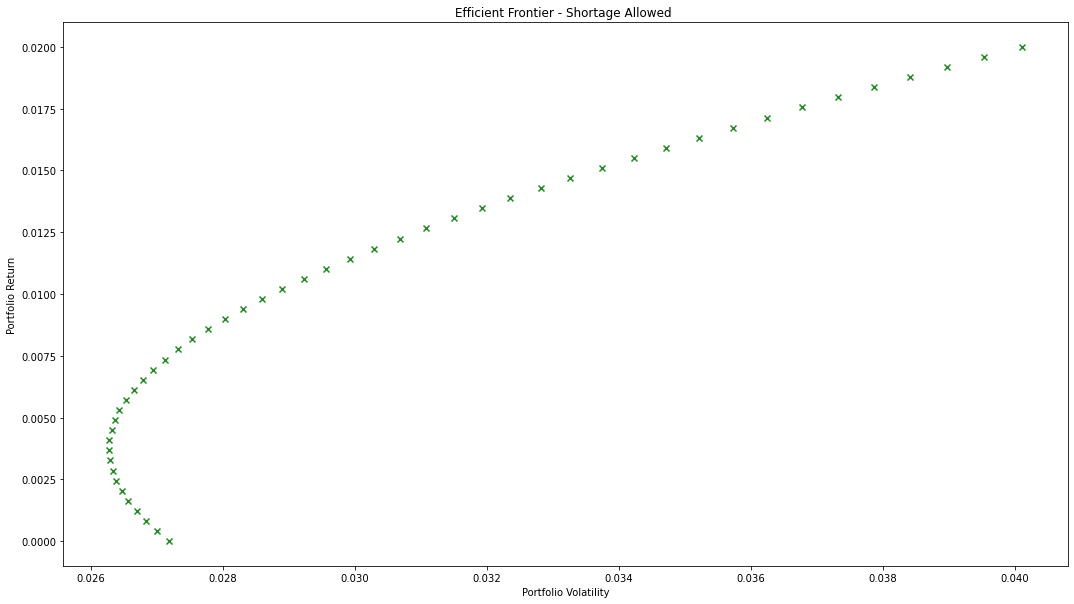

In [41]:
num_assets = len(returns.columns)
target_returns = np.linspace(0,0.02, 50)

portfolio_list_min_var=pd.DataFrame()
for target_return in target_returns:
    constraints = ({'type':'eq','fun': lambda weights: portfolio_parameters(weights, returns)['return']-target_return},
                   {'type':'eq','fun': lambda weights: np.sum(weights)-1})
    #bounds = tuple((0,1) for x in range(num_assets))
    initializer = num_assets * [1./num_assets,]

    optimal_variance=optimize.minimize(fun=minimize_volatility,
                                     x0=initializer,
                                     method = 'SLSQP',
                                     #bounds = bounds,
                                     constraints = constraints)

    weights_ = optimal_variance['x'].round(4)  
    weights_df = pd.DataFrame(weights_, index=returns.columns).T.rename({0:target_return},axis=0)
    portfolio_parameters_df = pd.DataFrame.from_dict(portfolio_parameters(weights_, returns), orient='index').T.rename({0:target_return},axis=0)
    portfolio_summary = pd.concat([weights_df,portfolio_parameters_df], axis=1)
    portfolio_list_min_var = portfolio_list_min_var.append(portfolio_summary)

    
plt.figure(figsize=(18,10))

plt.scatter(portfolio_list_min_var["std"],
            portfolio_list_min_var["return"],
            c='forestgreen',
            marker = 'x')
plt.title('Efficient Frontier - Shortage Allowed ')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')

Text(0, 0.5, 'Portfolio Return')

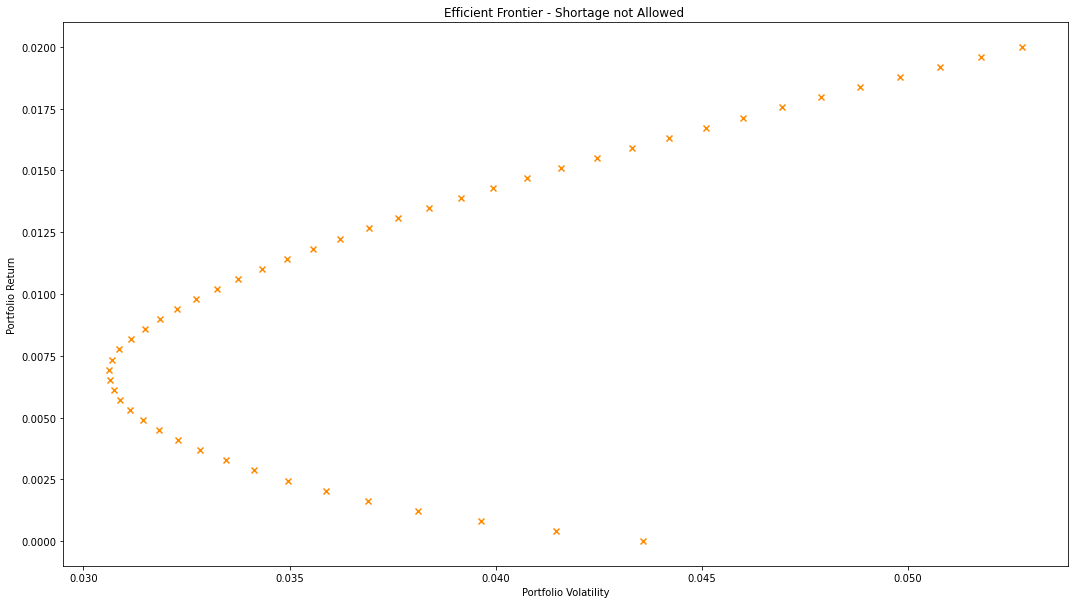

In [42]:
num_assets = len(returns.columns)
target_returns = np.linspace(0,0.02, 50)

portfolio_list_min_var=pd.DataFrame()
for target_return in target_returns:
    constraints = ({'type':'eq','fun': lambda weights: portfolio_parameters(weights, returns)['return']-target_return},
                   {'type':'eq','fun': lambda weights: np.sum(weights)-1})
    bounds = tuple((0,1) for weights in range(num_assets))
    initializer = num_assets * [1./num_assets,]

    optimal_variance=optimize.minimize(fun=minimize_volatility,
                                     x0=initializer,
                                     method = 'SLSQP',
                                     bounds = bounds,
                                     constraints = constraints)

    weights_ = optimal_variance['x'].round(4)  
    weights_df = pd.DataFrame(weights_, index=returns.columns).T.rename({0:target_return},axis=0)
    portfolio_parameters_df = pd.DataFrame.from_dict(portfolio_parameters(weights_, returns), orient='index').T.rename({0:target_return},axis=0)
    portfolio_summary = pd.concat([weights_df,portfolio_parameters_df], axis=1)
    portfolio_list_min_var = portfolio_list_min_var.append(portfolio_summary)

plt.figure(figsize=(18,10))

plt.scatter(portfolio_list_min_var["std"],
            portfolio_list_min_var["return"],
            c='darkorange',
            marker = 'x')
plt.title('Efficient Frontier - Shortage not Allowed ')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')

**Q3 .Add a risk-free rate using the current Central Bank rates for loans and apply the one fund
theorem.**

###### Method 1

In [43]:
risk_free_rate=interest_rates.mean()
risk_free_rate

rate    0.002234
dtype: float64

In [44]:
inverse_cov = pd.DataFrame(np.linalg.inv(returns.cov()),columns=returns.columns, index=returns.columns)
inverse_cov

,AEFES,AKBNK,DEVA,DGKLB,ECILC,ENJSA,ENKAI,GOLTS,IHLGM,SISE,THYAO,TTKOM,TTRAK,ULKER,VESTL
AEFES,939.667385,-98.686102,16.644785,-15.597500,51.397687,-224.374621,-41.915391,-61.648313,-5.585027,-113.535001,-208.819221,-80.117724,37.665491,-260.468650,51.411961
AKBNK,-98.686102,886.012772,57.584558,116.191643,44.538934,-11.522197,-125.423685,-29.075746,19.561932,125.350412,-334.715179,-528.181384,-39.389781,-190.902425,119.743522
DEVA,16.644785,57.584558,378.978044,-93.760356,-284.066735,-253.177243,154.724310,9.511472,139.088316,46.480865,-47.934128,-6.190655,-34.945804,-133.136710,23.847038
DGKLB,-15.597500,116.191643,-93.760356,330.830733,69.820768,-48.248488,-338.707888,-36.841013,-80.850072,45.031616,-80.952150,-143.407939,-68.401064,96.323419,-3.185464
ECILC,51.397687,44.538934,-284.066735,69.820768,376.658362,273.147818,-116.225101,-36.687219,-144.550500,18.856694,-18.957859,-150.623461,20.833533,57.965486,10.938953
ENJSA,-224.374621,-11.522197,-253.177243,-48.248488,273.147818,1243.632427,13.232000,-144.265354,-38.409870,3.922260,147.001414,-167.885869,-47.566279,79.726569,-139.805274
ENKAI,-41.915391,-125.423685,154.724310,-338.707888,-116.225101,13.232000,1164.794373,49.744579,77.446493,-246.249518,180.222197,224.338233,-29.900149,-70.289934,-149.924136
GOLTS,-61.648313,-29.075746,9.511472,-36.841013,-36.687219,-144.265354,49.744579,308.940383,-19.199800,-38.057771,-26.541830,97.052015,-62.600802,-35.871184,-41.364554
IHLGM,-5.585027,19.561932,139.088316,-80.850072,-144.550500,-38.409870,77.446493,-19.199800,284.858129,21.822266,-65.366872,21.825302,-58.965625,-150.066093,-25.331442
SISE,-113.535001,125.350412,46.480865,45.031616,18.856694,3.922260,-246.249518,-38.057771,21.822266,693.806519,-148.741315,-257.737523,-46.642635,-86.792385,84.725747


In [45]:
right_handside = pd.DataFrame([i-risk_free_rate for i in returns.mean()])
v_values = pd.DataFrame(np.dot(inverse_cov,right_handside['rate']),index=inverse_cov.columns)
v_values.columns=['v_val']
v_values['weights']=v_values['v_val']/v_values['v_val'].sum()
v_values

,v_val,weights
AEFES,-0.761085,-0.347757
AKBNK,-0.487945,-0.222953
DEVA,3.168676,1.447840
DGKLB,-1.569893,-0.717320
ECILC,-0.450080,-0.205652
ENJSA,-0.036015,-0.016456
ENKAI,-1.279705,-0.584726
GOLTS,0.952483,0.435211
IHLGM,1.252197,0.572157
SISE,4.651464,2.125359


In [46]:
one_fund_mean_1 = np.sum(returns.mean()*v_values['weights'])
one_fund_var_1 = np.dot(v_values['weights'].T, (np.dot(returns.cov(),v_values['weights'])))
print('mean and variance according to one fund with method 1:',round(one_fund_mean_1,4),'&',round(one_fund_var_1,4))

mean and variance according to one fund with method 1: 0.1352 & 0.0608


##### Method 2

In [47]:
def portfolio_parameters(weights, returns):
    weights = np.array(weights)
    port_return = np.sum(right_handside['rate'] * weights)
    port_var = np.dot(weights.T, np.dot(returns.cov(), weights))

    return {'return': port_return, 'variance': port_var, 'std': np.sqrt(port_var)}

# Objective Function
def minimize_volatility(weights):  
    return -portfolio_parameters(weights, returns)['return']/portfolio_parameters(weights, returns)['std']

In [48]:
num_assets = len(returns.columns)
constraints = ({'type':'eq','fun': lambda weights: np.sum(weights)-1})

initializer = num_assets * [1./num_assets,]

optimal_variance=optimize.minimize(fun=minimize_volatility,
                                 x0=initializer,
                                 method = 'SLSQP',
                                 #bounds = bounds,
                                 constraints = constraints)

print(optimal_variance)

weights_ = optimal_variance['x'].round(4)
portfolio_parameters(weights_, returns)

     fun: -0.5395137373074391
     jac: array([ 4.71249223e-05, -1.04270875e-04,  2.54385173e-04, -6.08712435e-06,
        2.97248363e-04, -9.37655568e-05,  1.04017556e-04, -2.60844827e-05,
        4.83170152e-05,  1.31726265e-05, -2.40653753e-06, -1.20110810e-04,
       -1.51902437e-04, -7.58245587e-05, -1.06252730e-04])
 message: 'Optimization terminated successfully'
    nfev: 768
     nit: 48
    njev: 48
  status: 0
 success: True
       x: array([-0.33293662, -0.22194887,  1.44418178, -0.71511987, -0.20373046,
       -0.02406029, -0.56517432,  0.43252322,  0.57187806,  2.11113323,
       -2.2455371 , -0.3782425 ,  2.75896101, -3.66053759,  2.02861032])


{'return': 0.1319712104214963,
 'variance': 0.059834736924274504,
 'std': 0.24461139982485383}

In [49]:
question_3=pd.DataFrame()
question_3['method_1']=v_values['weights']
question_3['method_2']=optimal_variance['x']
question_3

,method_1,method_2
AEFES,-0.347757,-0.332937
AKBNK,-0.222953,-0.221949
DEVA,1.447840,1.444182
DGKLB,-0.717320,-0.715120
ECILC,-0.205652,-0.203730
ENJSA,-0.016456,-0.024060
ENKAI,-0.584726,-0.565174
GOLTS,0.435211,0.432523
IHLGM,0.572157,0.571878
SISE,2.125359,2.111133


In [50]:
one_fund_mean_method_2 = np.sum(returns.mean()*question_3['method_2'])
one_fund_var_method_2 = np.dot(question_3['method_2'].T, (np.dot(returns.cov(),question_3['method_2'])))
print('mean and variance according to one fund with method_2:',round(one_fund_mean_method_2,4),'&',round(one_fund_var_method_2,4))

mean and variance according to one fund with method_2: 0.1342 & 0.0598


**Q4.Assuming the weekly return of a portfolio is normally distributed with the
average and standard deviation you have calculated for the optimal weights
calculate the probability of gaining return above the inflation (risk free return)
rate. Compare the result with the previous portion of the assignment. Comment.**

In [51]:
one_fund=pd.DataFrame()
one_fund["z-value"] = (risk_free_rate - one_fund_mean_1) / np.sqrt(one_fund_var_1)
one_fund["p-value"] = one_fund["z-value"].apply(lambda z: stats.norm.sf(abs(z)))
one_fund["probability"] = 1- one_fund["p-value"] 
one_fund

,z-value,p-value,probability
rate,-0.539518,0.294765,0.705235
